# Ames Housing Data and Kaggle Challenge
### Part 5: Presentation Model and Plots

I wanted to focus my presentation on inference rather than prediction, however the model I've been using for Kaggle has grown to be quite complex. In this notebook, I will create a new model that is simpler and lends itself inference. I'll also conduct a bit more EDA and generate the plots for my presentation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn import metrics
import pickle
import statsmodels.api as sm

Import my cleaned data:

In [2]:
ames = pd.read_csv('../datasets/ames_housing_cleaned.csv')

In [3]:
ames.head()

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,59,0,0,0,0,0,3,2010,WD,138500


Based on the modeling I had done previously for Kaggle, there are several features that I think are simple enough to explain and include here:
- Overall Quality
- Garage Area
- Neighbordhood Average*
- Lot Area
- Kitchen Quality**
- Basement Condition**
- Exterior Quality**
- Gr Living Area (Above Grade Sq Ft)
- Year Built/Remodeled*
- Porch/Deck*
- Bed/Bath*
- Paved Driveway**
- Central Air**

The features with one asterisk above are features that I engineered and those with two asterisks are dummied. I'll replicate those changes below:

First, the features that I engineered:

Perhaps the most complicated, this feature puts emphasis on the price of each neighborhood by assigning a dummy value based on the average home price in that area:

In [4]:
neighbor_avg = ames.groupby(ames['neighborhood'])['saleprice'].mean()
print(neighbor_avg)

neighborhood
Blmngtn    200417.681818
Blueste    144566.666667
BrDale     103371.052632
BrkSide    128857.094595
ClearCr    220684.615385
CollgCr    202359.544944
Crawfor    205976.600000
Edwards    131576.503937
Gilbert    188947.618182
Greens     188666.666667
GrnHill    330000.000000
IDOTRR     104439.571429
Landmrk    137000.000000
MeadowV    100231.250000
Mitchel    170645.512821
NAmes      147701.682274
NPkVill    140476.470588
NWAmes     194619.022989
NoRidge    316294.125000
NridgHt    321783.966387
OldTown    126439.158228
SWISU      134758.875000
Sawyer     138600.859813
SawyerW    192210.750000
Somerst    226654.567797
StoneBr    329675.736842
Timber     240492.872340
Veenker    253570.588235
Name: saleprice, dtype: float64


In [5]:
neighborhoods = list(ames['neighborhood'].unique())
neighborhoods = sorted(neighborhoods)

In [6]:
neighb_dict = {neighborhood : round((avg/10_0000), 2) 
               for(neighborhood, avg) in zip(neighborhoods, neighbor_avg)}
print(neighb_dict)

{'Blmngtn': 2.0, 'Blueste': 1.45, 'BrDale': 1.03, 'BrkSide': 1.29, 'ClearCr': 2.21, 'CollgCr': 2.02, 'Crawfor': 2.06, 'Edwards': 1.32, 'Gilbert': 1.89, 'Greens': 1.89, 'GrnHill': 3.3, 'IDOTRR': 1.04, 'Landmrk': 1.37, 'MeadowV': 1.0, 'Mitchel': 1.71, 'NAmes': 1.48, 'NPkVill': 1.4, 'NWAmes': 1.95, 'NoRidge': 3.16, 'NridgHt': 3.22, 'OldTown': 1.26, 'SWISU': 1.35, 'Sawyer': 1.39, 'SawyerW': 1.92, 'Somerst': 2.27, 'StoneBr': 3.3, 'Timber': 2.4, 'Veenker': 2.54}


In [7]:
#Adapted from Daniel Kim's potato example

ames['neighborhood_avg'] = ames['neighborhood'].apply(lambda x: neighb_dict[x])

The next feature I engineerd looks at the interaction between the year the home was built and year it was rmeodeled (if any):

In [8]:
ames['built/remodel'] = ames['year_built'] * ames['year_remod/add']

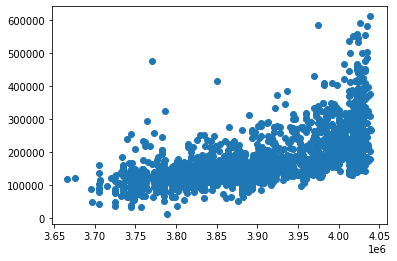

In [9]:
plt.scatter(ames['built/remodel'], ames['saleprice'])

Next, I created a feature that summed up all the outdoor living space such as porches and decks:

In [10]:
ames['porch/deck'] = ames['wood_deck_sf'] + ames['open_porch_sf'] + ames['enclosed_porch'] + ames['3ssn_porch'] + ames['screen_porch']


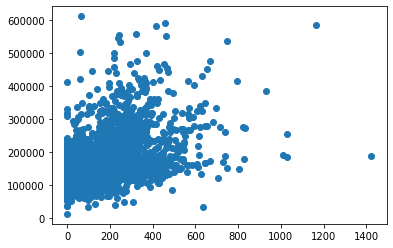

In [11]:
plt.scatter(ames['porch/deck'], ames['saleprice'])

The last feature I engineered was an interaction between beds and bathrooms:

In [12]:
ames['total_bath'] = ames['bsmt_full_bath'] + (ames['bsmt_half_bath'] *.5) + ames['full_bath'] + (ames['half_bath'] *.5)

In [13]:
ames['bed_bath'] = ames['bedroom_abvgr'] * ames['total_bath']

Now onto dummying these columns: Kitchen Quality, Basement Condition, Exterior Quality. Since these are ordinal, I'm going to create a new column for each that has a value based on the score:
- Excellent: 5
- Good: 4
- Typical/Average: 3
- Fair: 2
- Poor: 1

In [14]:
kitchens = list(ames['kitchen_qual'].unique())
kitchens = sorted(kitchens)

In [15]:
print(kitchens)

['Ex', 'Fa', 'Gd', 'TA']


In [16]:
kitchen_list = [5, 2, 4, 3]

In [17]:
kitchen_dict = {kitchen : num 
               for(kitchen, num) in zip(kitchens, kitchen_list)}
print(kitchen_dict)

{'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3}


In [18]:
#Adapted from Daniel Kim's potato example

ames['kitchen_score'] = ames['kitchen_qual'].apply(lambda x: kitchen_dict[x])

In [19]:
basements = list(ames['bsmt_cond'].unique())
basements = sorted(basements)

In [20]:
print(basements)

['Ex', 'Fa', 'Gd', 'Po', 'TA']


In [21]:
bsmt_list = [5, 2, 4, 1, 3]

In [22]:
bsmt_dict = {basement : num 
               for(basement, num) in zip(basements, bsmt_list)}
print(bsmt_dict)

{'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3}


In [23]:
ames['basement_score'] = ames['bsmt_cond'].apply(lambda x: bsmt_dict[x])

In [24]:
exts = list(ames['exter_qual'].unique())
exts = sorted(exts)

In [25]:
print(exts)

['Ex', 'Fa', 'Gd', 'TA']


In [26]:
ext_list = [5, 2, 4, 3]

In [27]:
ext_dict = {ext : num 
               for(ext, num) in zip(exts, ext_list)}
print(ext_dict)

{'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3}


In [28]:
ames['ext_score'] = ames['exter_qual'].apply(lambda x: ext_dict[x])

For Paved Drive and Central Air, I'll just create separate dummy columns:

In [29]:
drive = pd.get_dummies(ames['paved_drive'], drop_first=True, prefix='drive')

In [30]:
cent_air = pd.get_dummies(ames['central_air'], drop_first=True, prefix='CA')

Adding those dummy columns to my dataframe:

In [31]:
ames = pd.concat([ames, cent_air, drive], axis=1)

Now with all my features created I'll move on to making this much simpler model:

In [32]:
features_simple = ['overall_qual', 
                   'garage_area', 
                   'neighborhood_avg', 
                   'lot_area', 
                  'gr_liv_area',
                  'built/remodel',
                  'porch/deck',
                   'bed_bath',
                   'kitchen_score',
                   #'basement_score',
                   'ext_score'
                  ] + list(cent_air.columns) + list(drive.columns)


In [33]:
features_simple

['overall_qual',
 'garage_area',
 'neighborhood_avg',
 'lot_area',
 'gr_liv_area',
 'built/remodel',
 'porch/deck',
 'bed_bath',
 'kitchen_score',
 'ext_score',
 'CA_Y',
 'drive_P',
 'drive_Y']

In [34]:
X_simp = ames[features_simple]
y_simp = ames['saleprice']

Train/test split my data:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_simp, y_simp, random_state = 21)

Instantiating and fitting my model:

In [36]:
simp_mlr = LinearRegression()

In [37]:
simp_mlr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
simp_mlr.score(X_train, y_train)

0.8215982615391925

In [39]:
simp_mlr.score(X_test, y_test)

0.834498300668881

In [40]:
cross_val_score(simp_mlr, X_train, y_train).mean()

0.8136322878146192

In [41]:
predictions = simp_mlr.predict(X_train)

In [42]:
(metrics.mean_squared_error(y_train, predictions))**.5

33236.774837740384

This model is performing fairly well, well enough to draw some inferences so I'll pickle it:

In [43]:
pickle.dump(simp_mlr, open('../model/presentation_model.pkl', 'wb'))

In this next section, I'll be making the plot to add to my presentation:

In [44]:
ames['saleprice'].describe()

count      1969.000000
mean     182892.861859
std       78938.334289
min       12789.000000
25%      130000.000000
50%      163500.000000
75%      214900.000000
max      611657.000000
Name: saleprice, dtype: float64

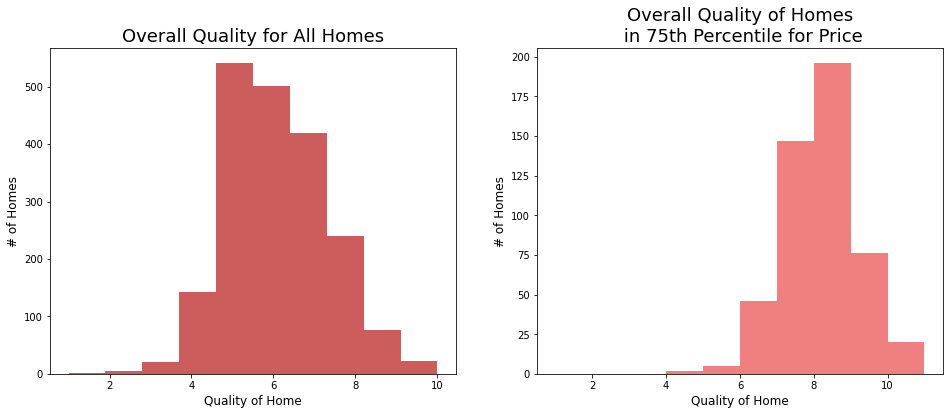

In [45]:
plt.figure(figsize=(16,6))


ax1 = plt.subplot(1, 2, 1)
plt.hist(ames['overall_qual'], color='indianred', bins=10)
plt.title('Overall Quality for All Homes', size=18)
plt.xlabel('Quality of Home', size=12)
plt.ylabel('# of Homes', size = 12)


plt.subplot(1, 2, 2, )
plt.hist(ames[ames['saleprice']>214900]['overall_qual'], color='lightcoral', bins=10, range = (1,11))
plt.title('Overall Quality of Homes\n in 75th Percentile for Price', size=18)
plt.xlabel('Quality of Home', size=12)
plt.ylabel('# of Homes', size = 12)
plt.subplots_adjust(hspace=.4)

plt.savefig('../plots/overall_quality_hist.png', dpi=235)

The figure above shows the different distribution of quality of homes for all the houses in our dataset vs those in the top 75% of sale price. This shows that the average quality shifts up for the more expensive homes.

overall_qual
1      61000.000000
2      45020.000000
3      76022.619048
4     109479.014085
5     134988.059150
6     162863.810379
7     203525.840095
8     271443.729167
9     370197.376623
10    415232.772727
Name: saleprice, dtype: float64


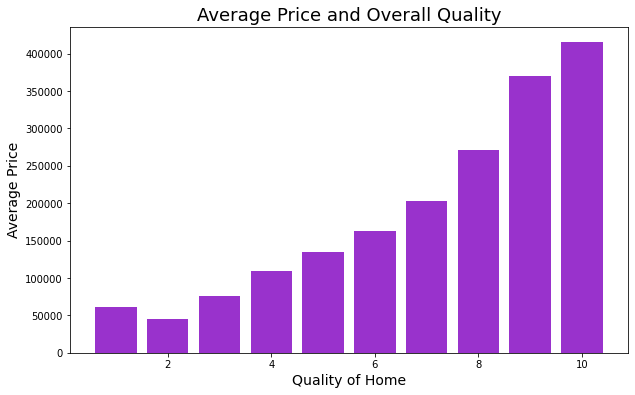

In [46]:
plt.figure(figsize=(10, 6))
x_qual = sorted(ames['overall_qual'].unique())
y_qual = ames.groupby('overall_qual')['saleprice'].mean()
print(y_qual)
plt.bar(x_qual, y_qual, color = 'darkorchid')
plt.title('Average Price and Overall Quality', size = 18)
plt.xlabel('Quality of Home', size=14)
plt.ylabel('Average Price', size = 14)
plt.savefig('../plots/overall_quality_bar.png', dpi=235)

The barchart above shows that as quality increases, the average sale price of the home also increases.

[kitchen_qual
Ex    336499.643836
Fa    107367.690476
Gd    212072.396154
TA    140920.264735
Name: saleprice, dtype: float64]


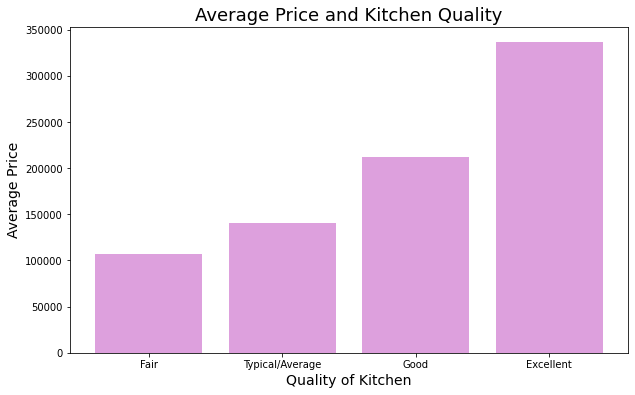

In [47]:
plt.figure(figsize=(10, 6))
x_qual = ['Fair', 'Typical/Average', 'Good', 'Excellent']
y = [107367, 140920, 212072, 336499]
y_qual = [ames.groupby('kitchen_qual')['saleprice'].mean()]
print(y_qual)
plt.bar(x_qual, y, color = 'plum')
plt.title('Average Price and Kitchen Quality', size = 18)
plt.xlabel('Quality of Kitchen', size=14)
plt.ylabel('Average Price', size = 14)
plt.savefig('../plots/kitch_quality_bar.png', dpi=235)

The barchart above shows that as kitchen quality increases (fair being the worst and excellent being the best), the average sale price of the home also increases.

[exter_qual
Ex    373328.562500
Fa     98627.545455
Gd    231064.853731
TA    144750.628237
Name: saleprice, dtype: float64]


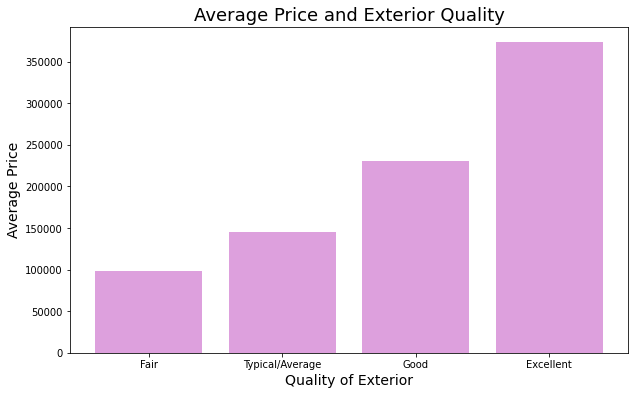

In [48]:
plt.figure(figsize=(10, 6))
x_qual = ['Fair', 'Typical/Average', 'Good', 'Excellent']
y = [98627, 144750, 231064, 373328 ]
y_qual = [ames.groupby('exter_qual')['saleprice'].mean()]
print(y_qual)
plt.bar(x_qual, y, color = 'plum')
plt.title('Average Price and Exterior Quality', size = 18)
plt.xlabel('Quality of Exterior', size=14)
plt.ylabel('Average Price', size = 14)
plt.savefig('../plots/ext_quality_bar.png', dpi=235)

The barchart above shows that as exterior quality increases (fair being the worst and excellent being the best), the average sale price of the home also increases.

Creating a new dataframe that just looks at the features I used so I can look at the correlations for these specific features:

In [49]:
model_df = ames[features_simple + ['saleprice']]

In [50]:
model_df.head()

,overall_qual,garage_area,neighborhood_avg,lot_area,gr_liv_area,built/remodel,porch/deck,bed_bath,kitchen_score,ext_score,CA_Y,drive_P,drive_Y,saleprice
0,6,475.0,1.39,13517,1479,3961880,44,7.5,4,4,1,0,1,130500
1,7,559.0,1.92,11492,2122,3986012,74,14.0,4,4,1,0,1,220000
2,5,246.0,1.48,7922,1057,3919671,52,6.0,4,3,1,0,1,109000
3,5,400.0,2.40,9802,1444,4026042,100,7.5,3,3,1,0,1,174000
4,6,484.0,1.92,14235,1445,3786700,59,6.0,3,3,1,0,0,138500


In [51]:
corr_matrix = model_df.corr().sort_values('saleprice')

In [52]:
corr_matrix['saleprice']

drive_P            -0.094971
CA_Y                0.250823
drive_Y             0.269017
lot_area            0.308461
porch/deck          0.401329
bed_bath            0.491081
built/remodel       0.615562
garage_area         0.651016
kitchen_score       0.686409
gr_liv_area         0.700919
ext_score           0.707184
neighborhood_avg    0.758861
overall_qual        0.797646
saleprice           1.000000
Name: saleprice, dtype: float64

[exter_qual
Ex    373328.562500
Fa     98627.545455
Gd    231064.853731
TA    144750.628237
Name: saleprice, dtype: float64]


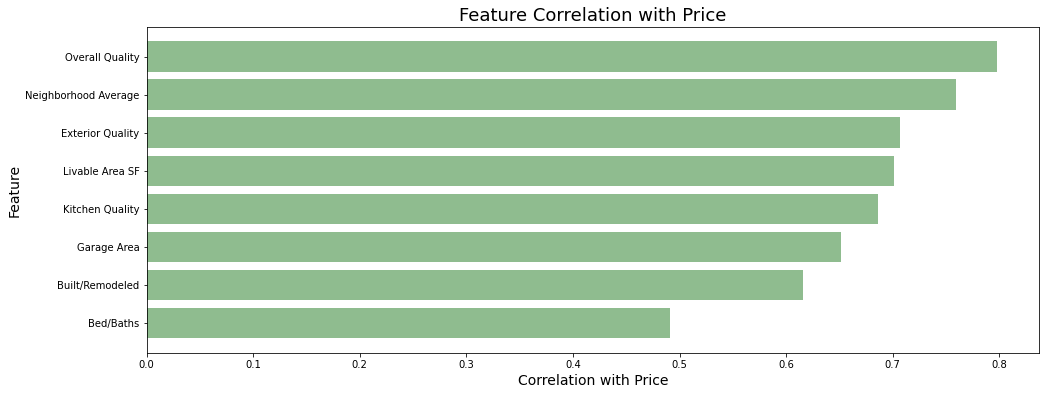

In [53]:
plt.figure(figsize=(16, 6))
x_qual = ['Bed/Baths','Built/Remodeled', 'Garage Area', 
          'Kitchen Quality', 'Livable Area SF', 'Exterior Quality', 'Neighborhood Average', 'Overall Quality']
y = [0.491081, 0.615562, 0.651016, 0.686409, 0.700919, 0.707184,  0.758861, 0.797646 ]
print(y_qual)
plt.barh(x_qual, y, color = 'darkseagreen')
plt.title('Feature Correlation with Price', size = 18)
plt.xlabel('Correlation with Price', size=14)
plt.ylabel('Feature', size = 14)
plt.savefig('../plots/corr.png')

In my presentation, I'm also going to do a demostration to show how the value of a particular house could increase by just changing the overall quality to 10. First, I'll need to find homes that are "perfect" in all categories so I can see what "perfect" looks like by looking up the homes on [Zillow](https://www.zillow.com/):

In [54]:
ames[(ames['overall_qual'] == 10) & (ames['kitchen_score'] == 5) & (ames['ext_score'] == 5)]

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,built/remodel,porch/deck,total_bath,bed_bath,kitchen_score,basement_score,ext_score,CA_Y,drive_P,drive_Y
132,2331,527210040,60,RL,18062,Pave,IR1,HLS,AllPub,CulDSac,...,4024036,238,3.5,17.5,5,3,5,1,0,1
191,448,528166060,20,RL,13472,Pave,Reg,Lvl,AllPub,Inside,...,4012009,353,2.0,6.0,5,3,5,1,0,1
193,524,528477050,60,FV,11003,Pave,Reg,Lvl,AllPub,Inside,...,4032064,220,3.5,10.5,5,3,5,1,0,1
319,1060,528118090,60,RL,12539,Pave,Reg,Lvl,AllPub,Inside,...,4022030,422,3.5,14.0,5,3,5,1,0,1
496,2276,921128030,20,RL,12633,Pave,IR1,HLS,AllPub,Inside,...,4026042,304,2.0,6.0,5,3,5,1,0,1
498,1178,533236090,160,FV,3951,Pave,IR1,Lvl,AllPub,Inside,...,3994002,184,3.5,7.0,5,3,5,1,0,1
508,432,528110010,60,RL,13478,Pave,IR1,Lvl,AllPub,Corner,...,4032064,656,3.5,10.5,5,3,5,1,0,1
597,421,528102040,20,RL,12456,Pave,Reg,Lvl,AllPub,FR2,...,4026042,264,3.0,9.0,5,3,5,1,0,1
598,457,528176030,20,RL,14836,Pave,IR1,HLS,AllPub,Inside,...,4018020,461,3.5,7.0,5,3,5,1,0,1
655,1053,528104050,20,RL,14803,Pave,Reg,Lvl,AllPub,Inside,...,4030056,233,3.0,6.0,5,3,5,1,0,1


Now I want to pinpoint some homes that are average or below average in quality and comprable to my example of the 1600 sq ft home from [Fixer Upper S2 Ep.10](https://magnolia.com/our-show/episode-10-the-raggedy-ranch/).

In [55]:
ames[(ames['gr_liv_area']<1650) & (ames['gr_liv_area']>1450) & (ames['overall_qual'] < 5)]['saleprice']



324     168000
342      85000
617      87500
676     118000
982      65000
1021    133000
1022    133500
1053    108000
1247     50000
1343    125000
1391    150000
1467    115000
1567    153000
1881    127000
Name: saleprice, dtype: int64

These houses look like good candidates:

In [56]:
demo = ames.loc[[1022, 1053, 1945], :]

Changing the overall quality to see how it change the price:

In [57]:
demo.loc[:,'overall_qual'] = 10

Now I'll make predictions with this change on just these houses:

In [58]:
X_demo = demo[features_simple]

In [59]:
demo_pred = simp_mlr.predict(X_demo)

In [60]:
demo['prediction'] = demo_pred

Here we can see the price chance dramatically for all three houses:

In [61]:
demo[['saleprice', 'prediction']]

,saleprice,prediction
1022,133500,209131.516021
1053,108000,191483.874487
1945,119000,189728.241585


Finally, I want to make sure that my model was somewhat accurate in predicting the original price of the home:

In [62]:
original_prediction = simp_mlr.predict(X_simp)

In [63]:
ames['model_prediction'] = original_prediction

In [64]:
ames.loc[1945, ['saleprice', 'model_prediction', 'overall_qual']]

saleprice           119000
model_prediction    122798
overall_qual             5
Name: 1945, dtype: object

In [65]:
ames.loc[1053, ['saleprice', 'model_prediction', 'overall_qual', 'gr_liv_area', 'pid']]

saleprice              108000
model_prediction       111167
overall_qual                4
gr_liv_area              1510
pid                 905480210
Name: 1053, dtype: object

These two houses were fairly accurate in the first prediction so I'll use these in my presention